In [21]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Drops specific values in a dataframe
# if flag = 1, drops values less than 'val'
# if flag = 0, drops values greater than 'val'
def drop_values(dataframe, column, val, flag):
    if flag:
        return dataframe.drop(dataframe[column < val].index)
    else:
        return dataframe.drop(dataframe[column > val].index)
    
# Normalize the data
def norm(dataframe):
    return (dataframe - dataframe.describe().transpose()['mean'] / dataframe.describe().transpose()['std'])

# Air Quality Health Factor Function
# Pass NO2 concentration in ppb
# Pass O3 concentration in ppb
# Pass PM2.5 concentration in ug/m^3
def AQHI(NO2, O3, PM25):
    NO2_CONST = 0.000871
    O3_CONST = 0.000537
    PM25_CONST = 0.000487
    return((10/10.4)*100*(np.exp(NO2_CONST*NO2)-1+np.exp(O3_CONST*O3)-1+np.exp(PM25_CONST*PM25_CONST)-1))

# Remove outliers
def remove_outliers(dataframe):
    return dataframe[(np.abs(stats.zscore(dataframe)) < 3).all(axis=1)]
    
# Read in the egg sensor datasets
EGG1 = pd.read_pickle('pkl_datasets/EGG1_DATASET_3h.pkl')
EGG2 = pd.read_pickle('pkl_datasets/EGG2_DATASET_3h.pkl')
EGG4 = pd.read_pickle('pkl_datasets/EGG4_DATASET_3h.pkl')
# Drop columns
EGG1 = EGG1.drop(columns=['PM1.0[ug/m^3]', 'PM10.0[ug/m^3]',
                          'Temperature[degC]', 'Humidity[percent]', 'Pressure[Pa]',
                          'PM10_conc', 'PM10-2.5_conc', 'Air_Temperature', 'Relative_Humidity',
                          'O3[V]', 'NO2[V]', 'NO', 'NOx'])
EGG2 = EGG2.drop(columns=['PM1.0[ug/m^3]', 'PM10.0[ug/m^3]',
                          'Temperature[degC]', 'Humidity[percent]', 'Pressure[Pa]',
                          'PM10_conc', 'PM10-2.5_conc', 'Air_Temperature', 'Relative_Humidity',
                          'O3[V]', 'NO2[V]', 'NO', 'NOx'])
EGG4 = EGG4.drop(columns=['PM1.0[ug/m^3]', 'PM10.0[ug/m^3]',
                          'Temperature[degC]', 'Humidity[percent]', 'Pressure[Pa]',
                          'PM10_conc', 'PM10-2.5_conc', 'Air_Temperature', 'Relative_Humidity',
                          'O3[V]', 'NO2[V]', 'NO', 'NOx'])
# Compute AQHI for each egg
# EGG 1
EGG1['AQHI_EGG1'] = AQHI(EGG1['NO2[ppb]'], EGG1['O3[ppb]'], EGG1['PM2.5[ug/m^3]'])
EGG1['AQHI_Airpointer'] = AQHI(EGG1['NO2'], EGG1['O3'], EGG1['PM2.5_conc'])
# EGG 2
EGG2['AQHI_EGG2'] = AQHI(EGG2['NO2[ppb]'], EGG2['O3[ppb]'], EGG2['PM2.5[ug/m^3]'])
EGG2['AQHI_Airpointer'] = AQHI(EGG2['NO2'], EGG2['O3'], EGG2['PM2.5_conc'])
# EGG 4
EGG4['AQHI_EGG4'] = AQHI(EGG4['NO2[ppb]'], EGG4['O3[ppb]'], EGG4['PM2.5[ug/m^3]'])
EGG4['AQHI_Airpointer'] = AQHI(EGG4['NO2'], EGG4['O3'], EGG4['PM2.5_conc'])

0.055641034186964755

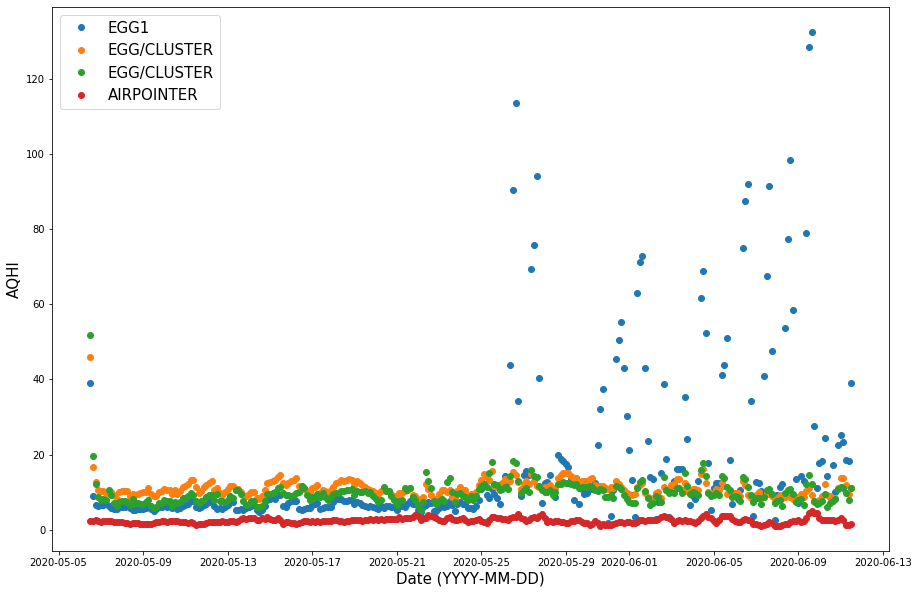

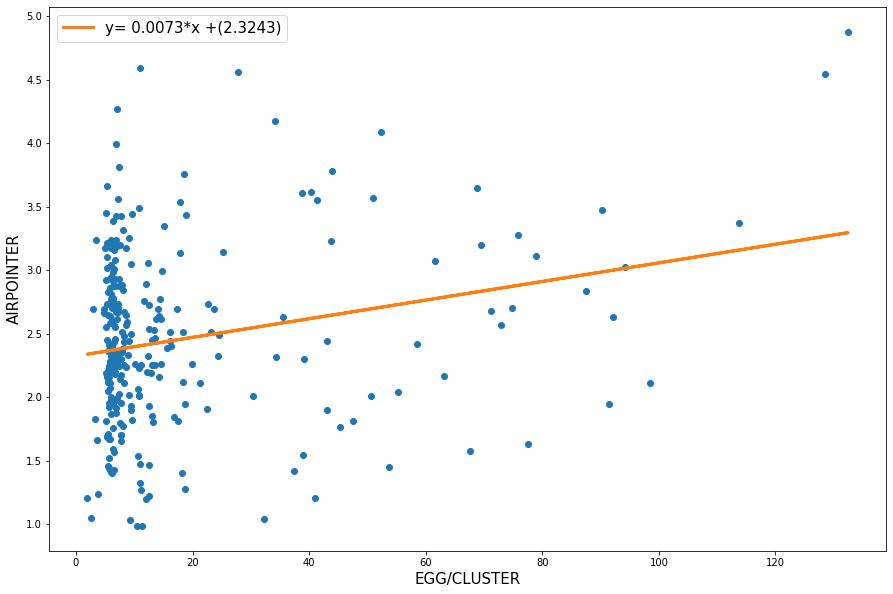

In [25]:
# ----------------------------- AQHI FROM CLUSTER vs. AQHI FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(EGG1.index.to_series(), EGG1['AQHI_EGG1'], 'o', label="EGG1")
plt.plot(EGG2.index.to_series(), EGG2['AQHI_EGG2'], 'o', label="EGG/CLUSTER")
plt.plot(EGG4.index.to_series(), EGG4['AQHI_EGG4'], 'o', label="EGG/CLUSTER")
plt.plot(EGG1.index.to_series(), EGG1['AQHI_Airpointer'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('AQHI', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = EGG1['AQHI_EGG1'].to_numpy()
# Airpointer
yValues = EGG1['AQHI_Airpointer'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))